In [1]:
%env MKL_THREADING_LAYER=GNU
%env THEANO_FLAGS=device=cpu,floatX=float64
# optimizer=fast_run,NanGuardMode.action=warn
# use device=cuda for gpu support

env: MKL_THREADING_LAYER=GNU
env: THEANO_FLAGS=device=cpu,floatX=float64


In [2]:
import sys
from __future__ import division
add = __builtin__.sum

In [3]:
from theano import clone, function, pp, shared
from theano.tensor import (concatenate, config, cosh, dot, erfinv, eq, grad, min,
                           scalar, scalars, shape_padright, sum, switch,
                           tensor3, tensor5, TensorType, tile, vector)
from theano.tensor.var import TensorVariable
from theano.printing import debugprint, pydotprint
#from theano.tensor.shared_randomstreams import RandomStreams
# used later
from theano.tensor import roll, stack

In [4]:
from numpy import (array, arange, asarray, exp, full, Inf, linspace,
                   mean, meshgrid, pi, roll)
# used later
#from numpy import roll, stack

In [5]:
from sympy import (Abs, Eq, exp as Exp, I, init_printing, integrate,
                   oo, pi as Pi, solve, symbols, Symbol)
#from sympy.printing.theanocode
# added erfinv
from theanocode import theano_code, theano_function
#from pymatrix import matrix, Matrix

In [6]:
init_printing(use_latex='mathjax')

In [7]:
from IPython.display import display, HTML, SVG

In [8]:
%matplotlib inline
from matplotlib.pyplot import (axes, close, contour, contourf, figure,
                               legend, plot, rcParams, show, title,
                               xlabel, ylabel)
from matplotlib.cm import * #coolwarm, Spectral, etc.
from mpl_toolkits.mplot3d import axes3d
from matplotlib import animation

In [9]:
from sdict import select
# E.g. select({3:3.2,2:2.2})[[2,3]] or
S=select({3:3.2,2:2.2})
S[array([2,3,2,2])]

array([ 2.2,  3.2,  2.2,  2.2])

In [10]:
from smatrix import *
# E.g.
print matrix([[1,2],[3,4]]).inverse()

-2   1

 1  -1


In [11]:
# function of specified variables fun(y,...) from expression f
# where: fun(x,y)(f)(x,y) = f
def fun(*y):
    if isinstance(y[0],TensorVariable):
        return lambda f: lambda *x: clone(f, dict([[y[i],x[i]] for i in range(len(y))]),strict=False)
    else:
        return lambda f: lambda *x: f.subs( dict([[y[i],x[i]] for i in range(len(y))]))

The multidimensional symbolic array $C$ represents a "uniformizing" mapping of worlds into configuration space, i.e. the position of each particle in each world.

In [12]:
dim = range(1) # dimension
C = TensorType(config.floatX, (False,)*(1+len(dim)))('C') # shape: d * N**d

#### Boundary Conditions

World outside the boundary of the simulation are assumed to be infinity far away. Expressions are adjusted by taking appropriate limits.

In [13]:
# uniform grid between 0 and 1 of dimension d and size N
def grid(d,N):
    return array(meshgrid(*[arange(0.0+0.5/N,1.0,1.0/N,config.floatX)]*d,
                              indexing='ij'))

### Difference operator ###

In [14]:
# In the following use numpy's roll and stack. Later we will use theano for these operations.
from numpy import roll, stack

In [15]:
N=5

In [16]:
x=array([symbols(['x_{%s}'%(str(Symbol("i")+(i-N//2)).replace(' ','')) for i in range(N)])])
x.shape

In [17]:
list(x[0])

The index of the $i^{th}$ world:

In [18]:
ith = N//2
x_i = x[0,ith]
x_i

Forward and backward differences

In [19]:
def d(dir,x,i):
    if dir<0:
        return roll(x, dir, axis = i) - x
    else:
        return x - roll(x, dir, axis = i)

In [20]:
d(+1,x[0],0)[ith]

In [21]:
d(-1,x[0],0)[ith]

Jacobian

In [22]:
def J(C): return matrix([[d(-1,C[j],i) for i in dim] for j in dim])

In [23]:
def K(C): return 1/J(C)

#### Density ####

In [24]:
def D(C): return 1/J(C).determinant()

In [25]:
Ds=D(x)

In [26]:
Ds[ith]

#### Quantum Potential (Schiff&Poirier eq. 20)####

In [27]:
def Q(hbar,mu,C):
    K_C = K(C)
    return add([add([add([
           -hbar**2/(4*mu[j])*(K_C[k,j]*d(-1,d(+1,K_C[l,j], k), l) + d(+1,K_C[l,j], l)*d(+1,K_C[k,j], k)/2)
                 for k in dim]) for j in dim]) for l in dim])

In [28]:
mu=array(symbols(['mu%s'%i for i in dim])) # mass
list(mu)

In [29]:
hbar=Symbol('hbar')

The quantum potential at the $i^{th}$ world:

In [30]:
Qs=Q(hbar,mu,x)

In [31]:
Qs[ith]

#### Quantum Force ####

In general the force is a vector.
Provided the number of worlds is large enough the trace of Q contains sufficient information to compute gradients.

In [32]:
QU=add(Qs) # trace in 1-d

In [33]:
R0 = -QU.diff(x_i); R0

 Schiff & Poirier eq 18

In [34]:
def R(hbar,mu,C):
    K_C=K(C)
    return stack([add([add([add([add([
      hbar**2/(4*mu[j])*d(+1,K_C[k, i]*K_C[p, j]*d(-1,d(+1,K_C[l, j], k), l), p)
        for p in dim]) for k in dim]) for j in dim]) for l in dim])
            for i in dim])

In [35]:
Rs=R(hbar,mu,x); Rs[0,ith]

The discretized Schiff and Poirier expression for the force is the gradient of the potential above.

In [36]:
Rs[0,ith].expand()==R0.expand()

True

It is interesting to note that the gradient of another expression for the potential which differs from the $2^{nd}$ order term from Schiff&Poirier eq. 20 by only the sign yields the same expression for the quantum force.

In [37]:
def Q2(hbar,mu,C):
    K_C = K(C)
    return add([add([add([
           hbar**2/(8*mu[j])*d(+1,K_C[l,j], l)*d(+1,K_C[k,j], k)
                 for k in dim]) for j in dim]) for l in dim])

In [38]:
Qs2=Q2(hbar,mu,x)

The discretized version of this expression is identical to that introduced by Hall & Deckart.

In [39]:
Qs2[ith]

In [40]:
Q2R0 = -add(Qs2).diff(x_i)

In [41]:
(Rs[0,ith] - Q2R0).simplify()==0

True

Boundary conditions

In [42]:
from sympy import Eq, limit, oo, Piecewise

In [43]:
i = Symbol('i')
n = Symbol('n')

Assume $x_i=\pm \infty$ outside the boundary of $0\le i\le n$:

In [44]:
Dn=Piecewise(
    (Ds[ith], i<n),
    (limit(Ds[ith],x[0,ith+1],+oo), i>=n)
)
Dn

In [45]:
Qn=Piecewise(
    (Qs2[ith], (i>0) & (i<n) ),
    (limit(Qs2[ith],x[0,ith-1],-oo), i<=0),
    (limit(Qs2[ith],x[0,ith+1],+oo), i>=n)
)
Qn

In [46]:
Rn=Piecewise(
    (limit(Rs[0,ith],x[0,ith-1],-oo), i<=0              ),
    (limit(Rs[0,ith],x[0,ith-2],-oo), Eq(i,1)           ),
    (Rs[0,ith],                       (i>1) & (i < n-1) ),
    (limit(Rs[0,ith],x[0,ith+2],+oo), Eq(i,n-1)         ),
    (limit(Rs[0,ith],x[0,ith+1],+oo), i>=n              )
)
Rn

### Numeric computation ###

These sympy expressions can be converted to theano functions for efficient execution on gpu and multicore processors.

In [47]:
from theano.tensor import arange as Arange, roll, stack

In [48]:
hbar_s = theano_code(hbar)
mu_v = vector('mu')
# boundary
#B = TensorType(config.floatX, (False,)*(1+len(dim)))('B') # shape: d * N**d [-2,-1,0,..., 0,1,2]
# mesh
C = TensorType(config.floatX, (False,)*(1+len(dim)))('C') # shape: d * N**d

Density

In [49]:
Db = fun(C)(clone(
    theano_code(Dn), # from sympy
    dict(
        [[theano_code(Symbol('n')),C[0].shape[0]-1]]+
        [[theano_code(Symbol('i')),Arange(C[0].shape[0])]]+
        [[theano_code(x[0,ith-i]),roll(C[0],i,axis=0)] for i in range(-1,2)]
        ), strict=False))
D_ = function([C],Db(C))

In [50]:
pp(D_.maker.fgraph.outputs[0])

"Elemwise{Composite{Switch(LT(i0, i1), inv((i2 + (-i3))), Switch(GE(i0, i1), i4, i5))}}[(0, 2)](ARange{dtype='int64'}(TensorConstant{0}, Shape_i{1}(C), TensorConstant{1}), (TensorConstant{(1,) of -1} + Shape_i{1}(C)), join(TensorConstant{0}, C[ScalarFromTensor(Elemwise{Composite{(-(i0 % i1))}}(TensorConstant{-1}, Shape_i{1}(C))), int64:], C[ScalarFromTensor(Elemwise{Composite{(-(i0 % i1))}}(TensorConstant{-1}, Shape_i{1}(C))), int64:int64]), join(TensorConstant{0}, C[ScalarFromTensor(Elemwise{Composite{(-(i0 % i1))}}[(0, 1)](TensorConstant{0}, Shape_i{1}(C))), int64:], C[ScalarFromTensor(Elemwise{Composite{(-(i0 % i1))}}[(0, 1)](TensorConstant{0}, Shape_i{1}(C))), int64:int64]), TensorConstant{(1,) of 0}, TensorConstant{[ nan]})"

$2^{nd}$ order potential

In [51]:
Q2b=fun(hbar_s,mu_v,C)(add([clone(
    theano_code(Qn), # from sympy
    dict(
         [[theano_code(Symbol('n')),C[0].shape[0]-1]]+
         [[theano_code(Symbol('i')),Arange(C[0].shape[0])]]+
         # scalar to vector
         [[theano_code(mu[0]),mu_v[j]]]+
         # indexed variable to vector operator
         [[theano_code(x[0,ith-i]),roll(C[j],i,axis=j)] for i in range(-1,2)]),
    strict=False) for j in dim]))
Q2b_ = function([hbar_s,mu_v,C],Q2b(hbar_s,mu_v,C))

In [52]:
pp(Q2b_.maker.fgraph.outputs[0])

"Elemwise{Composite{Switch(AND(GT(i0, i1), LT(i0, i2)), (i3 * i4 * i5 * sqr((inv((i6 + (-i7))) + (-inv((i7 + (-i8))))))), Switch(LE(i0, i1), (i3 * i4 * i5 * inv(sqr((i6 + (-i7))))), Switch(GE(i0, i2), (i3 * i4 * i5 * inv(sqr((i8 + (-i7))))), i9)))}}[(0, 6)](ARange{dtype='int64'}(TensorConstant{0}, Shape_i{1}(C), TensorConstant{1}), TensorConstant{(1,) of 0}, (TensorConstant{(1,) of -1} + Shape_i{1}(C)), TensorConstant{(1,) of 0.125}, sqr(hbar), inv(mu[Constant{0}]), join(TensorConstant{0}, C[ScalarFromTensor(Elemwise{Composite{(-(i0 % i1))}}(TensorConstant{-1}, Shape_i{1}(C))), int64:], C[ScalarFromTensor(Elemwise{Composite{(-(i0 % i1))}}(TensorConstant{-1}, Shape_i{1}(C))), int64:int64]), join(TensorConstant{0}, C[ScalarFromTensor(Elemwise{Composite{(-(i0 % i1))}}(TensorConstant{0}, Shape_i{1}(C))), int64:], C[ScalarFromTensor(Elemwise{Composite{(-(i0 % i1))}}(TensorConstant{0}, Shape_i{1}(C))), int64:int64]), join(TensorConstant{0}, C[ScalarFromTensor(Elemwise{Composite{(-(i0 % i1))}

Quantum force

In [53]:
Rb=fun(hbar_s,mu_v,C)(stack([clone(
   theano_code(Rn), # from sympy
   dict(
        [[theano_code(Symbol('n')),C[0].shape[0]-1]]+
        [[theano_code(Symbol('i')),Arange(C[0].shape[0])]]+
        # scalar to vector
        [[theano_code(mu[0]),mu_v[j]]]+
        # indexed variable to vector operator
        [[theano_code(x[0,ith-i]),roll(C[j],i,axis=j)] for i in range(-2,3)]),
   strict=False) for j in dim]))
Rb_ = function([hbar_s,mu_v,C],Rb(hbar_s,mu_v,C))

After optimization:

In [54]:
pp(Rb_.maker.fgraph.outputs[0])

"Elemwise{Composite{Switch(LE(i0, i1), (i2 * i3 * i4 * Composite{inv((i0 + (-i1)))}(i5, i6) * Composite{inv(Composite{(sqr(i0) * i0)}(i0))}((i5 + (-i7))) * (i7 + (i8 * i5) + (i9 * i6))), Switch(EQ(i0, i10), (i2 * i3 * i4 * Composite{inv((i0 + (-i1)))}(i5, i6) * Composite{inv(Composite{(sqr(i0) * i0)}(i0))}((i5 + (-i7))) * Composite{inv(Composite{(sqr(i0) * i0)}(i0))}((i11 + (-i7))) * ((i12 * Composite{(sqr(i0) * i0)}((i11 + (-i7))) * (i5 + (-i7))) + (i9 * Composite{(sqr(i0) * i0)}((i5 + (-i7))) * Composite{(i0 + (-i1))}(i6, i5)) + (i9 * Composite{(sqr(i0) * i0)}((i11 + (-i7))) * Composite{(i0 + (-i1))}(i6, i5)) + (sqr((i5 + (-i7))) * Composite{(i0 + (-i1))}(i6, i5) * (i11 + (-i7))) + (sqr((i11 + (-i7))) * (i5 + (-i7)) * Composite{(i0 + (-i1))}(i6, i5)))), Switch(AND(GT(i0, i10), LT(i0, i13)), (i2 * i3 * i4 * ((inv(sqr((i5 + (-i7)))) * (inv(Composite{(i0 + (-i1))}(i6, i5)) + inv((i7 + (-i11))) + (i14 * inv((i5 + (-i7)))))) + (i12 * inv(sqr((i7 + (-i11)))) * (inv((i5 + (-i7))) + Composit

### Simulation ###

Using the expressions derived above we can generate efficient numerical functions which we use later in determining the motion of a particle in many worlds simultaneously.

We use the discrete difference approximation to Poirier's equations above for a numerical simulation of quantum motion in a small number of ``parallel'' worlds.

#### Classical Potential ####

Poirier's problem

In [55]:
alpha,x0,B0,x1=scalars('alpha','x0','B0','x1')
poirier={alpha:asarray(2.5,config.floatX),x0:asarray(0.0,config.floatX),B0:asarray(0.0024,config.floatX)}

In [56]:
# symbolic
V = fun(x1) (clone(B0 / cosh(alpha * (x1-x0))**2, poirier))

In [57]:
xv=vector('xv')
V_ = function([xv],V(xv))

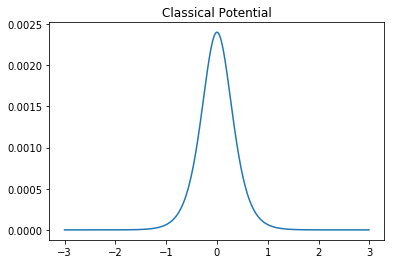

In [58]:
plot(arange(-3,3,0.01,config.floatX), V_(arange(-3,3,0.01,config.floatX)))
title('Classical Potential')
show()

#### Classical Force ####

In [59]:
# symbolic gradient
Fx = fun(x1) (-grad(V(x1),x1))

In [60]:
Fx_ = function([xv],Fx(xv))

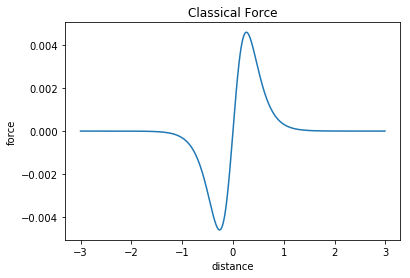

In [61]:
plot(arange(-3,3,0.01,config.floatX), Fx_(arange(-3,3,0.01,config.floatX)))
title('Classical Force')
xlabel('distance'); ylabel('force')
show()

### Initial Data ###

In order to compute the quantum force on the particles in world $n$ we introduce four widely separated fictitious particles in worlds to the left and right to represent open boundary conditions.

For example consider the spatial distribution of a Gaussian ensemble of one particle in  $N$ "parallel" worlds.

In [62]:
N = 5000

#### Spatial Distribution

For example consider the spatial distribution of a Gaussian ensemble of one particle in  $N$ ``parallel'' worlds. Everything is in atomic units below, so $\hbar=1$.

In [63]:
#from sympy import Abs, Symbol,pi as Pi, I, exp as Exp, integrate, oo, solve, Eq
#x = Symbol("x", real=True)
alpha = Symbol("alpha", positive=True)
x0 = Symbol("x0", real=True)
m = Symbol("m", real=True)
v = Symbol("v", real=True)
x1 = Symbol("x1", real=True)
x2 = Symbol("x2", real=True)
y1 = Symbol("y1", real=True)
model1={m:2000,alpha:0.70,v:0.00164317,x0:-7.0}
Wx=Abs((alpha/Pi)**(1/4)*Exp(-(alpha/2)*(x1-x0)**2)*Exp(I*m*v*x1))**2
Wx

In [64]:
Wx.subs(model1)

In [65]:
W=theano_function([x1],[Wx.subs(model1)], dims={x1: 1}, dtypes={x1: config.floatX})

We may compute a monotonic uniformizing mapping into this distribution by inverting the cummulative distribution.

In [66]:
cumWx = integrate(Wx,(x1,-oo,x2)); cumWx

In [67]:
erfinv0=solve(Eq(y1,cumWx),x2)[0]
erfinv0

In [68]:
erfinv0.subs(model1)

In [69]:
erfinv1=theano_function([y1],[erfinv0.subs(model1)], dims={y1: 2}, dtypes={y1: config.floatX})

In [70]:
crosses=fun(C)(min(Db(C))<0)

In [71]:
p0 = erfinv1(grid(1,N))
p0.shape

In [72]:
D_(p0).shape

In [73]:
crosses(p0).eval()

array(False, dtype=bool)

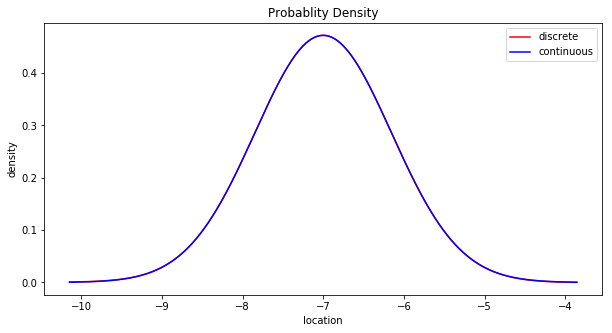

In [74]:
figure(figsize=(10,5))
plot(p0[0], D_(p0)/N, color='red',label='discrete')
plot(p0[0], W(p0[0]), color='blue',label='continuous')
legend()
title('Probablity Density')
xlabel('location'); ylabel('density')
show()

#### Distribution of Velocity ####
The particles have an identical initial velocity in each world of

In [75]:
v0=array([full(N,v.subs(model1),config.floatX)]); v0.shape

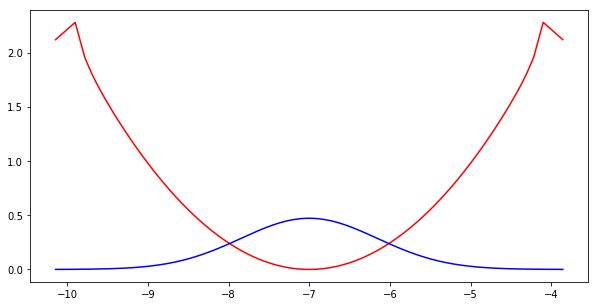

In [76]:
figure(figsize=(10,5))
plot(p0[0], Q2b_(1,[1],p0), color='red')
plot(p0[0], W(p0[0]), color='blue')
show()

In [77]:
Rb_(1,[1],p0).shape

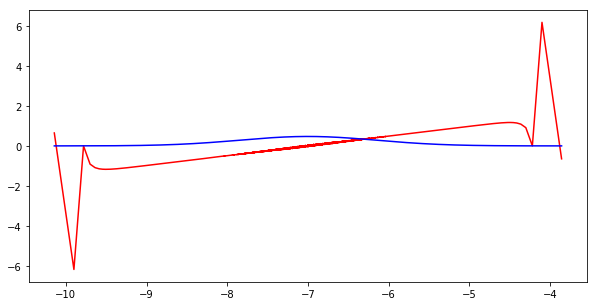

In [78]:
figure(figsize=(10,5))
plot(p0[0], Rb_(1,[1],p0)[0], color='red')
plot(p0[0], W(p0[0]), color='blue')
show()

#### Acceleration ####

In [79]:
def A(hbar,mu,x):
    #debound(clone(theano_code(r2),ro,strict=False))
    return (1/mu[0])*(Fx(x[0]) + Rb(hbar,mu,x))[0]

#### Step Size Controller ####
Continuous integrating step size controller \cite{hairer2005}

In [162]:
def G(a,v):
    alpha = 0.0 # sensitivity
    eps = 1e-12
    g1 = sum(a*v)
    g2 = sum(v*v)
    return switch(eq(g2,0),1/eps,-alpha*g1/g2)

#### Integration ####
Integrate using the Störmer–Verlet algorithm with adaptive step size.

In [163]:
mu = array([2000.0])  # mass
hbar = 1.0  # Planck's constant

In [164]:
rho = shared(asarray(1.0, config.floatX))
ds = scalar()
dt = ds/rho
t = shared(asarray(0.0, config.floatX))
x = shared(p0)

In [165]:
a0 = A(hbar,mu,x).eval()

In [166]:
a = shared(a0)
v = shared(v0)
x_new = x+v*dt+0.5*a*dt**2
a_new = A(hbar,mu,x_new)
v_new = v+0.5*a*dt+0.5*a_new*dt

In [167]:
VerletStep = function([ds],t, updates=[
    (rho, rho + G(a,v)*dt ),
    (x, x_new ),
    (v, v_new ),
    (a, a_new ),
    (t, t + dt)
],allow_input_downcast=True)

#### Energy ####

In [168]:
KU1 = 0.5*mu[0]*sum(v*v)  # total kinetic energy
PU1 = sum(V(x[0]))             # total classical potential
QU1 = sum(Q2b(hbar,mu,x))            # total quantum potential
E_ = function([],[KU1,PU1,QU1])

In [169]:
E_()

[array(13.500038244500788),
 array(9.598058652348208e-11),
 array(0.43745617479016785)]

In [170]:
crossing=function([],crosses(x))

In [171]:
t_start = 0.0; t_end = 10000.0;

t_samples = 100; x_samples = 100
t_sample = t_end/t_samples
x_sample = __builtin__.max(1,int(N)//int(x_samples))
x_start = __builtin__.max(0,int(N-x_samples*x_sample)//int(2))
XS = array(range(x_start,N-x_start-1,x_sample))

#ds0 = 0.01 # N=1000 # initial step size
ds0 = 0.000175 # N=5000
#ds0 =  0.00008 # 0.0000001 # N=10000
#ds0 =  0.0000008 # 0.0000001 # N=100000
dsn = 1 # initial step size divider

In [172]:
from theano.tensor import isnan,any

In [173]:
checkxnan=function([],any(isnan(x)))
checkvnan=function([],any(isnan(v)))
checkanan=function([],any(isnan(a)))

In [174]:
if checkanan(): print("a NaN")
if checkvnan(): print("v NaN")
if checkxnan(): print("x NaN")

In [175]:
while True:
    try: # step size
        ds = ds0/dsn
        # initial values
        rho0 = 1.0
        rho.set_value(rho0)
        t.set_value(t_start)
        x.set_value(p0)
        v.set_value(v0)
        a.set_value(a0)
        # recording
        T = [t_start]
        Rho = select({t_start:rho.get_value().item()})
        XX = select({t_start:x.get_value()[0][XS]})
        XV = select({t_start:v.get_value()[0][XS]})
        [KK,PP,QQ] = E_()
        E1 = KK+PP+QQ  # total energy
        TK = select({t_start:KK})
        TP = select({t_start:PP})
        TQ = select({t_start:QQ})
        E = select({t_start:E1})
        
        try:
            t0 = t_start
            while t0<t_end:
                t1 = t0 + t_sample
                while t0<t1:
                    rho0 = rho.get_value().item()
                    if rho0 > 100 or rho0 < 0.01:
                        raise ValueError("Step control failed at %s. rho=%s"%(t0,rho0))
                    t0 = VerletStep(ds).item()
                    if checkanan(): raise ValueError("a NaN")
                if checkvnan(): raise ValueError("v NaN")
                if checkxnan(): raise ValueError("x NaN")
                # Check no-crossing
                if crossing()<0:
                    raise ValueError("crossing at %s",t)
                # Check total energy conservation
                [KK,PP,QQ] = E_()
                E2 = KK+PP+QQ
                print "t =", t0, "t1 =",t1,"rho =", rho0, "Delta E =",E1-E2
                sys.stdout.flush()
                if abs(E1-E2)/N>1e-10:
                    raise ValueError(
                        "Energy conservation bound failed at %s. Delta E:"\
                        "|%s|/N > 1e-10."%(t0,E1-E2))
                E1 = E2
                T += [t0]; XX[t0] = x.get_value()[0][XS]; XV[t0] = v.get_value()[0][XS]
                Rho[t0] = rho.get_value().item(); TK[t0] = KK; TP[t0] = PP; TQ[t0] = QQ; E[t0] = E1
                #t0 = t.get_value().item()
        except KeyboardInterrupt:
            print "Interrupted at %s ..."%(t0)
            T += [t0]; XX[t0] = x.get_value()[0][XS]; XV[t0] = v.get_value()[0][XS]
            Rho[t0] = rho.get_value().item(); TK[t0] = KK; TP[t0] = PP; TQ[t0] = QQ; E[t0] = E1
        tmax = t0
        break
    except ValueError as msg:
        print msg
        dsn = dsn + 1
        print "Trying a shorter initial step size: %s."%(ds0/dsn)
        #continue
T=array(T)
print "t =", tmax

t = 100.00025 t1 = 100.0 rho = 1.0 Delta E = -1.44240175359e-12


t = 200.000499999 t1 = 200.00025 rho = 1.0 Delta E = -1.81366033303e-12


t = 300.000750002 t1 = 300.000499999 rho = 1.0 Delta E = -2.6645352591e-12


t = 400.001000009 t1 = 400.000750002 rho = 1.0 Delta E = -2.24709140184e-12


t = 500.001250016 t1 = 500.001000009 rho = 1.0 Delta E = -1.66267000168e-12


t = 600.001500024 t1 = 600.001250016 rho = 1.0 Delta E = -1.54543045028e-12


t = 700.001750031 t1 = 700.001500024 rho = 1.0 Delta E = -1.45483625147e-12


t = 800.002000039 t1 = 800.001750031 rho = 1.0 Delta E = -1.27897692437e-12


t = 900.002250046 t1 = 900.002000039 rho = 1.0 Delta E = -1.03383968053e-12


t = 1000.00250005 t1 = 1000.00225005 rho = 1.0 Delta E = -1.11732845198e-12


t = 1100.00275006 t1 = 1100.00250005 rho = 1.0 Delta E = -1.20259358027e-12


t = 1200.00300007 t1 = 1200.00275006 rho = 1.0 Delta E = -7.92255150373e-13


t = 1300.00325008 t1 = 1300.00300007 rho = 1.0 Delta E = -1.42819089888e-12


t = 1400.00350008 t1 = 1400.00325008 rho = 1.0 Delta E = -7.35411731512e-13


t = 1500.00375009 t1 = 1500.00350008 rho = 1.0 Delta E = -6.53699316899e-13


t = 1600.0040001 t1 = 1600.00375009 rho = 1.0 Delta E = -8.33111357679e-13


t = 1700.0042501 t1 = 1700.0040001 rho = 1.0 Delta E = -3.67705865756e-13


t = 1800.00450011 t1 = 1800.0042501 rho = 1.0 Delta E = -5.3290705182e-13


t = 1900.00475012 t1 = 1900.00450011 rho = 1.0 Delta E = -6.09290395914e-13


t = 2000.00500013 t1 = 2000.00475012 rho = 1.0 Delta E = 5.68434188608e-14


t = 2100.0052501 t1 = 2100.00500013 rho = 1.0 Delta E = -3.39284156325e-13


t = 2200.00550004 t1 = 2200.0052501 rho = 1.0 Delta E = -8.34887714518e-14


t = 2300.00574999 t1 = 2300.00550004 rho = 1.0 Delta E = -1.20792265079e-13


t = 2400.00599993 t1 = 2400.00574999 rho = 1.0 Delta E = -7.28306304154e-14


t = 2500.00624987 t1 = 2500.00599993 rho = 1.0 Delta E = -1.06581410364e-13


t = 2600.00649981 t1 = 2600.00624987 rho = 1.0 Delta E = -1.95399252334e-13


t = 2700.00674976 t1 = 2700.00649981 rho = 1.0 Delta E = -6.57252030578e-14


t = 2800.0069997 t1 = 2800.00674976 rho = 1.0 Delta E = 1.06581410364e-13


t = 2900.00724964 t1 = 2900.0069997 rho = 1.0 Delta E = -1.63424829225e-13


t = 3000.00749958 t1 = 3000.00724964 rho = 1.0 Delta E = 5.68434188608e-14


t = 3100.00774952 t1 = 3100.00749958 rho = 1.0 Delta E = -4.08562073062e-14


t = 3200.00799947 t1 = 3200.00774952 rho = 1.0 Delta E = 8.34887714518e-14


t = 3300.00824941 t1 = 3300.00799947 rho = 1.0 Delta E = -9.23705556488e-14


t = 3400.00849935 t1 = 3400.00824941 rho = 1.0 Delta E = 5.15143483426e-14


t = 3500.00874929 t1 = 3500.00849935 rho = 1.0 Delta E = 2.84217094304e-14


t = 3600.00899924 t1 = 3600.00874929 rho = 1.0 Delta E = 9.41469124882e-14


t = 3700.00924918 t1 = 3700.00899924 rho = 1.0 Delta E = 1.01252339846e-13


t = 3800.00949912 t1 = 3800.00924918 rho = 1.0 Delta E = -1.13686837722e-13


a NaN
Trying a shorter initial step size: 0.000175.


t = 100.000074999 t1 = 100.0 rho = 1.0 Delta E = 9.96536186904e-13


t = 200.000150004 t1 = 200.000074999 rho = 1.0 Delta E = 4.68958205602e-13


t = 300.000225012 t1 = 300.000150004 rho = 1.0 Delta E = -6.37356833977e-12


t = 400.000300019 t1 = 400.000225012 rho = 1.0 Delta E = -2.03570493795e-12


t = 500.000375027 t1 = 500.000300019 rho = 1.0 Delta E = -6.10533845702e-12


t = 600.000450034 t1 = 600.000375027 rho = 1.0 Delta E = -4.1389114358e-12


t = 700.000525041 t1 = 700.000450034 rho = 1.0 Delta E = -2.71072053692e-12


t = 800.000600049 t1 = 800.000525041 rho = 1.0 Delta E = -1.92201810023e-12


t = 900.000675056 t1 = 900.000600049 rho = 1.0 Delta E = -1.21502807815e-12


t = 1000.00075006 t1 = 1000.00067506 rho = 1.0 Delta E = -1.66267000168e-12


t = 1100.00082502 t1 = 1100.00075006 rho = 1.0 Delta E = -1.72306613422e-12


t = 1200.00089996 t1 = 1200.00082502 rho = 1.0 Delta E = -7.49622586227e-13


t = 1300.00097491 t1 = 1300.00089996 rho = 1.0 Delta E = -2.14939177567e-12


t = 1400.00104985 t1 = 1400.00097491 rho = 1.0 Delta E = -2.10143014101e-12


t = 1500.00112479 t1 = 1500.00104985 rho = 1.0 Delta E = -2.14761541883e-12


t = 1600.00119973 t1 = 1600.00112479 rho = 1.0 Delta E = -2.4389379405e-12


t = 1700.00127468 t1 = 1700.00119973 rho = 1.0 Delta E = -1.33937305691e-12


t = 1800.00134962 t1 = 1800.00127468 rho = 1.0 Delta E = -7.24753590475e-13


t = 1900.00142456 t1 = 1900.00134962 rho = 1.0 Delta E = -9.68114477473e-13


t = 2000.0014995 t1 = 2000.00142456 rho = 1.0 Delta E = -6.73239242133e-13


t = 2100.00157451 t1 = 2100.0014995 rho = 1.0 Delta E = -1.1137757383e-12


t = 2200.00164959 t1 = 2200.00157451 rho = 1.0 Delta E = 1.50990331349e-13


t = 2300.00172466 t1 = 2300.00164959 rho = 1.0 Delta E = -9.16600129131e-13


t = 2400.00179973 t1 = 2400.00172466 rho = 1.0 Delta E = -1.15285558877e-12


t = 2500.0018748 t1 = 2500.00179973 rho = 1.0 Delta E = -5.09814412908e-13


t = 2600.00194987 t1 = 2600.0018748 rho = 1.0 Delta E = -6.89226453687e-13


t = 2700.00202495 t1 = 2700.00194987 rho = 1.0 Delta E = -1.82431847406e-12


t = 2800.00210002 t1 = 2800.00202495 rho = 1.0 Delta E = 1.86517468137e-13


t = 2900.00217509 t1 = 2900.00210002 rho = 1.0 Delta E = -7.56728013585e-13


t = 3000.00225016 t1 = 3000.00217509 rho = 1.0 Delta E = 0.0


t = 3100.00232524 t1 = 3100.00225016 rho = 1.0 Delta E = -5.08038056068e-13


t = 3200.00240031 t1 = 3200.00232524 rho = 1.0 Delta E = -9.55679979597e-13


t = 3300.00247538 t1 = 3300.00240031 rho = 1.0 Delta E = 3.57047724719e-13


t = 3400.00255045 t1 = 3400.00247538 rho = 1.0 Delta E = -2.27373675443e-13


t = 3500.00262553 t1 = 3500.00255045 rho = 1.0 Delta E = -8.881784197e-14


t = 3600.0027006 t1 = 3600.00262553 rho = 1.0 Delta E = 2.3625545964e-13


t = 3700.00277567 t1 = 3700.0027006 rho = 1.0 Delta E = 4.61852778244e-14


t = 3800.00285074 t1 = 3800.00277567 rho = 1.0 Delta E = -1.61648472385e-13


t = 3900.00292582 t1 = 3900.00285074 rho = 1.0 Delta E = -2.39808173319e-13


t = 4000.00300089 t1 = 4000.00292582 rho = 1.0 Delta E = -2.98427949019e-13


t = 4100.00307596 t1 = 4100.00300089 rho = 1.0 Delta E = -2.85993451143e-13


t = 4200.00315103 t1 = 4200.00307596 rho = 1.0 Delta E = 8.34887714518e-13


t = 4300.0032261 t1 = 4300.00315103 rho = 1.0 Delta E = -5.34683408659e-13


t = 4400.00330118 t1 = 4400.0032261 rho = 1.0 Delta E = 7.9936057773e-13


t = 4500.00337625 t1 = 4500.00330118 rho = 1.0 Delta E = 3.00204305859e-13


t = 4600.00345132 t1 = 4600.00337625 rho = 1.0 Delta E = 1.00719432794e-12


t = 4700.00352639 t1 = 4700.00345132 rho = 1.0 Delta E = 5.57776047572e-13


t = 4800.00360147 t1 = 4800.00352639 rho = 1.0 Delta E = 1.05337960576e-12


t = 4900.00367654 t1 = 4900.00360147 rho = 1.0 Delta E = 1.94173566115e-11


t = 5000.00375161 t1 = 5000.00367654 rho = 1.0 Delta E = 1.04789066313e-10


t = 5100.00382668 t1 = 5100.00375161 rho = 1.0 Delta E = 3.14267722956e-10


t = 5200.00390176 t1 = 5200.00382668 rho = 1.0 Delta E = 1.99817051794e-10


t = 5300.00397683 t1 = 5300.00390176 rho = 1.0 Delta E = 1.15997167427e-09


t = 5400.0040519 t1 = 5400.00397683 rho = 1.0 Delta E = 1.49919188175e-09


t = 5500.00412697 t1 = 5500.0040519 rho = 1.0 Delta E = 2.21034035519e-09


t = 5600.00420205 t1 = 5600.00412697 rho = 1.0 Delta E = 1.18603793453e-10


t = 5700.00427712 t1 = 5700.00420205 rho = 1.0 Delta E = 1.70371627917e-09


t = 5800.00435219 t1 = 5800.00427712 rho = 1.0 Delta E = 2.36945929544e-09


t = 5900.00442726 t1 = 5900.00435219 rho = 1.0 Delta E = -3.51965567802e-10


t = 6000.00450233 t1 = 6000.00442726 rho = 1.0 Delta E = 1.66645008903e-09


t = 6100.00457741 t1 = 6100.00450233 rho = 1.0 Delta E = -7.57864881962e-11


t = 6200.00465248 t1 = 6200.00457741 rho = 1.0 Delta E = 1.06980557746e-09


t = 6300.00472755 t1 = 6300.00465248 rho = 1.0 Delta E = -2.57702836848e-09


t = 6400.00480262 t1 = 6400.00472755 rho = 1.0 Delta E = 3.77225184423e-09


t = 6500.0048777 t1 = 6500.00480262 rho = 1.0 Delta E = -3.99078636804e-09


t = 6600.00495277 t1 = 6600.0048777 rho = 1.0 Delta E = 6.99932556358e-10


t = 6700.00502784 t1 = 6700.00495277 rho = 1.0 Delta E = 2.61588617434e-09


t = 6800.00510291 t1 = 6800.00502784 rho = 1.0 Delta E = -1.62451740948e-09


t = 6900.00517799 t1 = 6900.00510291 rho = 1.0 Delta E = 2.10645900722e-09


t = 7000.00525306 t1 = 7000.00517799 rho = 1.0 Delta E = 9.80502790071e-10


t = 7100.00532813 t1 = 7100.00525306 rho = 1.0 Delta E = 1.52931889374e-10


t = 7200.0054032 t1 = 7200.00532813 rho = 1.0 Delta E = -1.11625020338e-09


t = 7300.00547828 t1 = 7300.0054032 rho = 1.0 Delta E = -7.60877583161e-10


t = 7400.00555335 t1 = 7400.00547828 rho = 1.0 Delta E = 9.47835587795e-10


t = 7500.00562842 t1 = 7500.00555335 rho = 1.0 Delta E = -1.59288049417e-09


t = 7600.00570349 t1 = 7600.00562842 rho = 1.0 Delta E = 4.69530192504e-10


t = 7700.00577856 t1 = 7700.00570349 rho = 1.0 Delta E = -2.74392419897e-09


t = 7800.00585364 t1 = 7800.00577856 rho = 1.0 Delta E = 1.63287516841e-09


t = 7900.00592871 t1 = 7900.00585364 rho = 1.0 Delta E = -6.35758112821e-11


t = 8000.00600378 t1 = 8000.00592871 rho = 1.0 Delta E = -3.7117686702e-10


t = 8100.00607885 t1 = 8100.00600378 rho = 1.0 Delta E = 8.52086401437e-10


t = 8200.00615388 t1 = 8200.00607885 rho = 1.0 Delta E = -2.87384516184e-09


t = 8300.00622844 t1 = 8300.00615388 rho = 1.0 Delta E = -1.00172137252e-09


t = 8400.00630299 t1 = 8400.00622844 rho = 1.0 Delta E = 7.98342725261e-10


t = 8500.00637754 t1 = 8500.00630299 rho = 1.0 Delta E = 6.8842709311e-10


t = 8600.0064521 t1 = 8600.00637754 rho = 1.0 Delta E = -4.99490226957e-10


t = 8700.00652665 t1 = 8700.0064521 rho = 1.0 Delta E = -7.37855998523e-10


t = 8800.0066012 t1 = 8800.00652665 rho = 1.0 Delta E = -1.25422516817e-09


t = 8900.00667575 t1 = 8900.0066012 rho = 1.0 Delta E = 1.76024528287e-10


t = 9000.00675031 t1 = 9000.00667575 rho = 1.0 Delta E = -2.92429191973e-10


t = 9100.00682486 t1 = 9100.00675031 rho = 1.0 Delta E = -5.55306911565e-10


t = 9200.00689941 t1 = 9200.00682486 rho = 1.0 Delta E = -3.65917074419e-10


t = 9300.00697396 t1 = 9300.00689941 rho = 1.0 Delta E = 1.05599085032e-10


t = 9400.00704852 t1 = 9400.00697396 rho = 1.0 Delta E = -8.20516987687e-10


t = 9500.00712307 t1 = 9500.00704852 rho = 1.0 Delta E = 6.91708024192e-10


t = 9600.00719762 t1 = 9600.00712307 rho = 1.0 Delta E = -1.04058095474e-09


t = 9700.00727217 t1 = 9700.00719762 rho = 1.0 Delta E = 3.06259906324e-10


t = 9800.00734673 t1 = 9800.00727217 rho = 1.0 Delta E = -9.12304898293e-10


t = 9900.00742128 t1 = 9900.00734673 rho = 1.0 Delta E = 6.76745770534e-10


t = 10000.0074958 t1 = 10000.0074213 rho = 1.0 Delta E = -7.91617438267e-10


t = 10000.0074958


Step Density

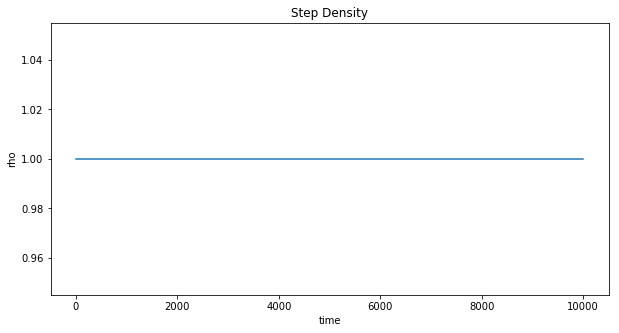

In [176]:
figure(figsize=(10,5))
plot(T, Rho[T])
title('Step Density')
xlabel('time'); ylabel('rho')
show()

#### Quantum Potential, Classical Potential and Kinetic Energy ####

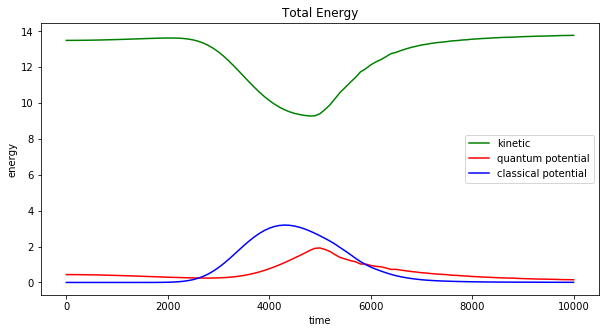

In [177]:
figure(figsize=(10,5))
plot(T, TK[T],color='green',label='kinetic')
plot(T, TQ[T],color='red',label='quantum potential')
plot(T, TP[T],color='blue',label='classical potential')
legend()
title('Total Energy')
xlabel('time'); ylabel('energy')
show()

#### Energy Conservation ####

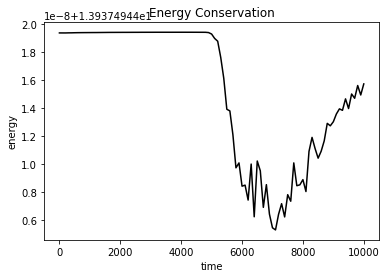

In [178]:
plot(T, E[T],color='black')
title('Energy Conservation')
xlabel('time'); ylabel('energy')
show()

#### Trajectories ####
The trajectory of the particle in each world is shown below.  Notice how the trajectories do not cross, yet in some worlds the particle is scattered from the barrier while in others the particle tunnels across the barrier "pushed" by its counterpart in other worlds.

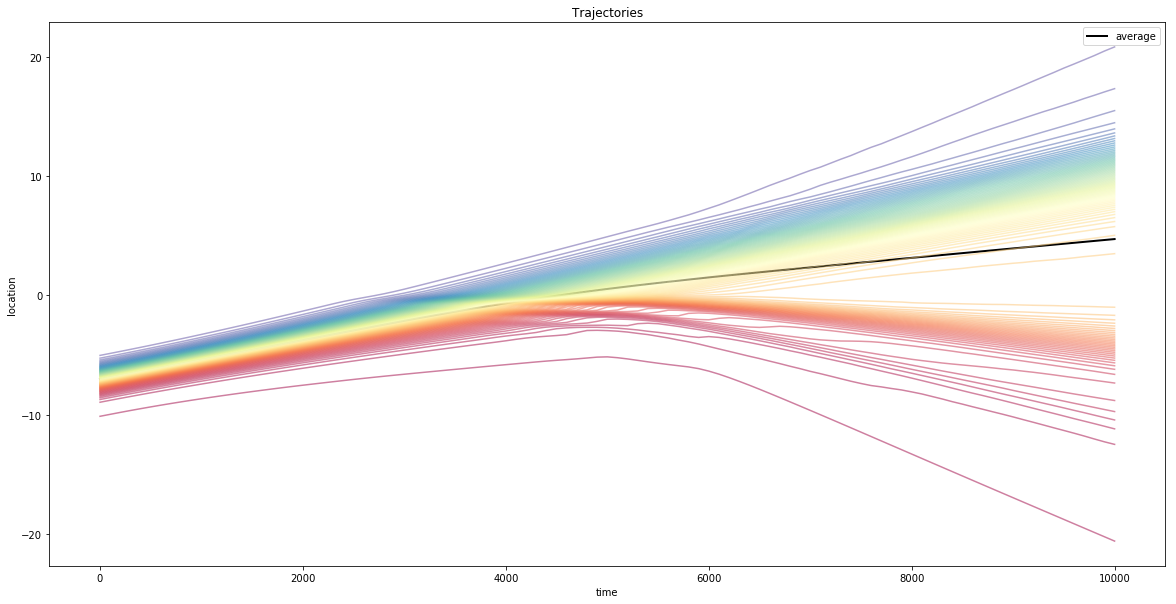

In [179]:
figure(figsize=(20,10))
plot(T, mean(XX[T],1), color='black',label='average',linewidth=2)
line_color = Spectral(linspace(0,1,len(XS)))
for i in range(len(XS)):
    plot(T, XX[T][:,i],color=line_color[i],alpha=0.5)
legend()
title('Trajectories')
xlabel('time'); ylabel('location')
show()

#### Final Distribution ####
The distribution at the end of the simulation shows the reflected and transmitted "wave packets" separating from each other.

In [180]:
fig = figure(figsize=(10,5))
ax = axes()
ax.set_xlim(( -10, 15))
ax.set_ylim((0, 0.5))
line, = ax.plot([], [], lw=2)
def animate(t):
    line.set_data(XX[t],D_([XX[t]])/x_samples)
    return (line,)
ani=animation.FuncAnimation(fig, animate, frames=T, interval=100, blit=True)
close()
HTML(ani.to_html5_video())

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAD7fm1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTQ4IHIyNzQ4IDk3ZWFlZjIgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE2IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9OSBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA4fZYiE
AD///vdonwKbWkN6gOSVxSXbT4H/q2dwfI/pAwAAAwAAAwAAAwAj/AuQLzeVYYFgAAADADTKM53r
GUX75gGz2cz0TTv0El47e3Yw4B+326uO2qlBeAOkUMVXppBgq74IYhWLQfPCdbGJA6ZCeQC1MpYa
JAmCbV7IJXXlx4Qta4jrADTMlscZgzZdQK8aZTrcwM4Qt9Pjf/sb/pV2M55MKrm3MyB/fMFsr112
dL4UVEaPCQYdHcncojSBP3zH8yKLinLTTpyj5BAu3s0ciSZ4ORHi0oaRoV/BtN2bZvJ6GHfJVQeO
8AWtBahJVuf/Kv6vMWATp0l5zyLN8soFyZYDlIW+iJaeBM/tXUQ8zTsXPgBQLZai2b7TqigHfWVE
6VCxN82yoZkvaoiSioPgg+/Cr+q71ddcdzeAh5QLeyhB9MmKX80uwWu3gE6YYUVcn8PRvEfmZQtR
TAASQnI5zqsVVLb/TYAcndGXdRgivuF4aAdgNe3sxYR8SfBUjhHeiHZR7ba7OcKgvPStlv6esNZo
IrhOQC7kG08jLHQ113f4WBmx5vbe+DrIXTx7MQOmZ0LpoIU5QF76NGDvevhpvOQlVJHxkoUpUpQF
PXY5DxYQi1ocANQgvP+s1sPEWAleLiT/ldZJ5jdWYikb0MVNUFPEDAdzlD2Ro/TEBWMviWtUwIbv
zwxEroUz0cfXV++YMRfzUnz+znDXVydpxiEeknUK/V1Y2BiBMbaVgL/RUePMmQijZG/TjnuCV8Z3
rz4j46xgnovhHuFHuZsIOtB4acUFar2dVD0075UiIAtzuciYWG+Gp6h77We9r1hdQO+5oLERZb8x
oANA8GQ9YgBAc2zZ85z1W0zfSEu19ds0/wJD9QFDAAx2mfICb3L0tiy9ZPtajL1Y5bhCfDp4ygsH
Iz3Oe3JDVFkroe5INriyj3mqaPTq1yESGa0fKmNkJTj42Fx+aivdWJdpvBiovQuJ/V3PZP3JndAk
AdCul5Zo9kLKJzs+gw+/b3F+EULmeYOi9umIFfU9zNtczxruLSXJYNghkOOLvqami2dSomDuwe1d
PZXgCV3XH7Y5NJmtIOe3Ien45MH6ZqDDcVhzGPNXclnTIwI+znPdqI1L5bVwFPMKXy1UGVdoTr1D
N0EqdOXyU7el2vU4pBFxhmpqAAiT0he2Rm9HqqETicAxR75ZNFqdZ5m6mJwQCI8KuREbyU7CHWqk
Vef0j0yRxwOIuNfdlBxVt76qL8gcivrxGfd88mc5j7SU+WUFO5jES/7eCoegsFyu5TAK84f5+5nw
zXUoAwN/Y9Y9+Me+1AHLl9mVlfZno9kFFmA+232z/fmUDwtiXS/IwXVl0MqkIFMtAG8e3setTvhJ
iLwjv9nSN+RwxEHkx4UYnyIDyeIcLPz+ewHJ3iML4UIhCsyuofMdFX9FjCUfJ8TND8MdTKvpMJyk
xcglnBCWShFvC3zJBDRgecZbhG7UIVucMudjHTPyquUABeR7FA5w0st4ans9QcpB2g3t9REogK2L
sLtirft3IT3YwVTf1fmukc5RuhjjuAFXeXjk3w+8P16p7oFozltjyGQmI5w/U9QIRJdC02DKB39J
tcJd0pVoxS98RBgDpNDCw3JAA8XexioChoQCG/IjDtbm8efWMczAFEFiVMcXABmZZCN17F+XgKvZ
a4OG0vLuVZ2zAH1u9USZa4voHOczX1SRqQOqm3TkaItp+BkRk5DbNvy5om7OBGCtOPfAMrh0KFtr
8CAfJoSI21owDjcxCW9gHnAFUQQkipBYNWmzy/hiasHFT4fw8V2NHucFLvaDhz+W4pisfJcdqXLv
gFwpbtkMAK/pTKWIUVgMf2JKJKLyvHDgAAAPaQx8wJIF7V45F56pHr45mMMkPP1ekB5c3aO7YO/R
s7HEGp5bKvmYTbbTMXPNP676e6AHAu/76RQwF+NWBSniTM11vQcN/0surRLIAAIPCigtNX1kB1jD
hesMX1EIYRnthLvmb680CMuCmA/CUxkRAq/HQX+SauBpxfTRSbeSMuIsPJ3XFF9SVIJqJPOuRHBG
sDFZBjnOgdwuG//NduHb+zgdLtdvvF8OoyiqAgv8q4x3fJ/5xFGn+dyoG6k6ms6qCdpszZ4AxQe1
SEgRyOR6FtO7S/DK6Yz3P4Wm395q2QXU7OT/OuDlwjzPyobOXxDKo7FLYs6mNfBRUE+xasshgtKS
VyXnlTlnoT0FMmhGYxJ+b4vr0J8POGqqBQsAyJheaeMqpK8mqSNg7Iol5Cmqr1IrV4TbffdvdsRg
nY8CxnS0h3QHHCrLHkYN3zxSSbtT8KHN7xPEBdajCmu4JQZqu6ThxCNlplwlQg4maGR7qE9iZEBw
lVTkM1a9YtWeVRsF2mnq7KziB3MHf2LjxEIENeFHdeRyfCEqxAe6orWnwJjYLsq7ywdpwHHYRlkz
9Htq+QpW2gVNlcLF6WgeLlFJJuxKZBWqNER/IS3/He7kBwhSLFRM1O/BT/8G3FFx1XNZupzbbLuu
4UpzNhgMyjuqNCRCPE3ZZZKR9t5xw6a+EOX9ESdz859NKnzlhIzFxopzoGgf3bd6r5t4MvCxJU2m
o8j+64BK2W5Y12SZGoBQRkNGkENkW+RQbFTKvYa5cIrfWf48dpxC1RYYqJODw9NnASDV4a1V//zW
lU3rV5jgYpAVc9dQr6hsw7YdD+vZiobZe+6VRCZV8vmWj82WEdBaUNWC/eqKcFg2I5sO+E6BBQJa
PASYE8QfyTamP54OP09y85dEgJTVx4/SGgn2b1DGlMJg8RppqdQBfdZmKYHjuvAZVCvloySucX6n
v4+m3X5RCUnvGDVIkn31fXjGwVV15V1NPzBeQViclxRB8lqp91OkSPmnPrd6USHM3/CFnGyjOa0r
Ge+ymAR1byicW90rotdWq

In greater detail ...

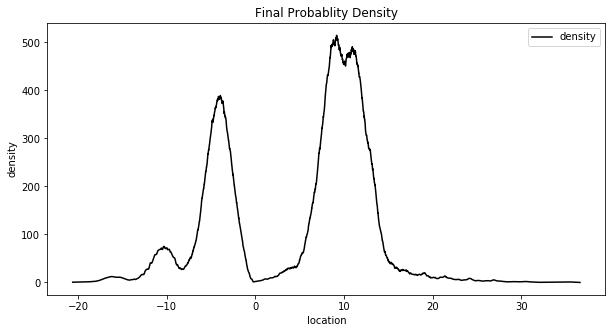

In [185]:
figure(figsize=(10,5))
plot(x.get_value()[0],D_(x.get_value()),color='black',label='density')
legend()
title('Final Probablity Density')
xlabel('location'); ylabel('density')
show()

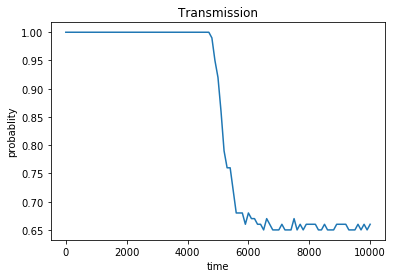

In [186]:
plot(T, mean(select(XV)[T]>0,1))
title('Transmission')
xlabel('time'); ylabel('probablity')
show()

Final transmission probability

In [187]:
print '%.4f'%(v.get_value()>0).mean()

0.6584
